<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2022/blob/main/16S_2022_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦠 Amplicon Sequencing Data Analysis with Qiime 2

This notebook will accompany the first session of the 2022 ISB Virtual Microbiome Series. The presentation slides can be [found here](https://gibbons-lab.github.io/isb_course_2022/16S). 

Save your own local copy of this notebook by using `File > Save a copy in Drive`. At some point you may be prompted to trust the notebook. We promise that it is safe 🤞

**Disclaimer:**

The Google Colab notebook environment will interpret any command as Python code by default. If we want to run bash commands we will have to prefix them by `!`. So any command you see with a leading `!` is a bash command and if you wanted to run it in your terminal you would omit the `!`. For example, if in the Colab notebook you ran `!wget` you would just run `wget` in your terminal. 

## Setup

QIIME 2 is usually installed by following the [official installation instructions](https://docs.qiime2.org/2022.8/install/). However, because we are using Google Colab and there are some caveats to using conda here, we will have to hack around the installation a little bit. But no worries, we provide a setup script below which does all this work for us. 😌 

So...let's start by pulling a local copy of the project repository down from GitHub.

In [1]:
!git clone https://github.com/gibbons-lab/isb_course_2022 materials

Cloning into 'materials'...
remote: Enumerating objects: 1124, done.
remote: Counting objects: 100% (313/313), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 1124 (delta 168), reused 283 (delta 151), pack-reused 811
Receiving objects: 100% (1124/1124), 263.50 MiB | 27.26 MiB/s, done.
Resolving deltas: 100% (470/470), done.
Checking out files: 100% (578/578), done.


We will switch to working within the `materials` directory for the rest of the notebook.

In [2]:
%cd materials

/content/materials


Now we are ready to set up our environment. This will take about 10-15 minutes. 

**Note**: This setup is only relevant for Google Colaboratory and will not work on your local machine. Please follow the [official installation instructions](https://docs.qiime2.org/2021.8/install/) for that.

In [3]:
%run setup_qiime2

[15:37:15] 🐍 Downloading miniconda...                                                              ]8;id=581195;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=978348;file:///content/materials/setup_qiime2#56\56]8;;\

[15:37:16] 🐍 Done.                                                                                 ]8;id=661823;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=942666;file:///content/materials/setup_qiime2#62\62]8;;\

           🐍 Installing miniconda...                                                               ]8;id=188324;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=779753;file:///content/materials/setup_qiime2#56\56]8;;\

[15:37:36] 🐍 Installed miniconda to `/usr/local`.                                                  ]8;id=744886;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=513412;file:///content/materials/setup_qiime2#62\62]8;;\

           🔍 Downloading Qiime 2 package list...                                                   ]8;id=948143;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=275161;file:///content/materials/setup_qiime2#56\56]8;;\

[15:37:37] 🔍 Done.                                                                                 ]8;id=131093;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=438406;file:///content/materials/setup_qiime2#62\62]8;;\

           🔍 Installing Qiime 2. This may take a little bit.                                       ]8;id=225727;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=651063;file:///content/materials/setup_qiime2#56\56]8;;\
            🕐                                                                                                     

[15:46:23] 🔍 Done.                                                                                 ]8;id=659860;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=293696;file:///content/materials/setup_qiime2#62\62]8;;\

           🌲 Installing Empress...                                                                 ]8;id=739409;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=194963;file:///content/materials/setup_qiime2#56\56]8;;\

[15:46:27] 🌲 Done.                                                                                 ]8;id=165586;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=5683;file:///content/materials/setup_qiime2#62\62]8;;\

           📊 Checking that Qiime 2 command line works...                                           ]8;id=794084;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=587137;file:///content/materials/setup_qiime2#56\56]8;;\

[15:46:37] 📊 Qiime 2 command line looks good 🎉                                                    ]8;id=915305;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=567084;file:///content/materials/setup_qiime2#62\62]8;;\

           🧹 Cleaned up unneeded files.                                                            ]8;id=71343;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=535573;file:///content/materials/setup_qiime2#51\51]8;;\

           Everything is A-OK. You can start using Qiime 2 now 👍                                  ]8;id=49598;file:///content/materials/setup_qiime2\setup_qiime2]8;;\:]8;id=146594;file:///content/materials/setup_qiime2#159\159]8;;\

---

While this is running let's get back to the presentation. 📚

---

<br>

## Our first QIIME 2 command

Let's remember our workflow for today.

![our workflow](https://github.com/Gibbons-Lab/isb_course_2022/raw/main/docs/16S/assets/steps.png)

The first thing we have to do is to get the data into an 'artifact'.
We can import the data with the `import` action from the tools. For that we have to give
QIIME 2 a *manifest* (list of raw files) and tell it what *type of data* we
are importing and what *type of artifact* we want. 

**QoL Tip:** QIIME 2 commands can get very long. To split them up over several lines we can use `\` which means "continue on the next line".

In [4]:
!qiime tools import \
  --type 'SampleData[PairedEndSequencesWithQuality]' \
  --input-path data/manifest.tsv \
  --output-path sequences.qza \
  --input-format PairedEndFastqManifestPhred33V2

Imported data/manifest.tsv as PairedEndFastqManifestPhred33V2 to sequences.qza


Since we have quality information for the sequencing reads, let's also generate
our first visualization to inspect sequence quality. 

---

Qiime 2 commands can become pretty long. Here are some pointers to remember the
structure of a command:

```
qiime plugin action --i-argument1 ... --o-argument2 ...
```

Argument types usually begin with a letter denoting their meaning:

- `--i-...` = input files
- `--o-...` = output files
- `--p-...` = parameters
- `--m-...` = metadata

---

In this case we will use the `summarize` action from the `demux` plugin with the previously generated artifact as input and output the resulting visualization to the `qualities.qzv` file.

In [5]:
!qiime demux summarize --i-data sequences.qza --o-visualization qualities.qzv

Saved Visualization to: qualities.qzv


You can view the plot by downloading the .qzv file and opening it using http://view.qiime2.org. To download the file click on the folder symbol to the left, open the `materials` folder, and choose download from the dot menu next to the `qualities.qzv` file.

🤔 What do you observe across the read? Where would you truncate the reads?

# Denoising amplicon sequence variants

We will now run the DADA2 plugin which will do 3 things:

1. filter and trim the reads
2. find the most likely set of unique sequences in the sample (ASVs)
3. remove chimeras
4. count the abundances of each ASV


Since this step takes a bit, let's start the process and use the time to
understand what is happening:

In [6]:
!qiime dada2 denoise-paired \
    --i-demultiplexed-seqs sequences.qza \
    --p-trunc-len-f 150 \
    --p-trunc-len-r 150 \
    --p-n-threads 2 \
    --output-dir dada2 --verbose

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada.R --input_directory /tmp/tmpr1ug5vyu/forward --input_directory_reverse /tmp/tmpr1ug5vyu/reverse --output_path /tmp/tmpr1ug5vyu/output.tsv.biom --output_track /tmp/tmpr1ug5vyu/track.tsv --filtered_directory /tmp/tmpr1ug5vyu/filt_f --filtered_directory_reverse /tmp/tmpr1ug5vyu/filt_r --truncation_length 150 --truncation_length_reverse 150 --trim_left 0 --trim_left_reverse 0 --max_expected_errors 2.0 --max_expected_errors_reverse 2.0 --truncation_quality_score 2 --min_overlap 12 --pooling_method independent --chimera_method consensus --min_parental_fold 1.0 --allow_one_off False --num_threads 2 --learn_min_reads 1000000

R version 4.1.3 (2022-03-10) 
Loading required package: Rcpp
DADA2: 1.22.0 / Rcpp: 1.0.9 / RcppParallel: 5.1.5 
2) Filteri

---

While this is running let's get back to the presentation. 📚

---

<br>


If this step takes too long or fails, you can also copy the results from the treasure chest with the following command.

In [7]:
# obscure magic that will only copy if the previous command failed
![ -d dada2 ] || cp -r treasure_chest/dada2 .

Ok, this step ran, but we should also make sure it kind of worked. One good way to tell if the identified ASVs are representative of the sample is to see how many reads were maintained throughout the pipeline. Here, the most common issues and solutions are:

**Large fraction of reads is lost during merging (only paired-end)**

![read overlap](https://gibbons-lab.github.io/isb_course_2022/16S/assets/read_overlap.png)

In order to merge ASVs DADA2 uses an overlap of 12 bases between forward and reverse reads by default. Thus, your reads must allow for sufficient overlap *after* trimming. So if your amplified region is 450bp long and you have 2x250bp reads and you trim the last 30 bases of each read, truncating the length to 220bp, the total length of covered sequence is 2x220 = 440 which is shorter than 450bp so there will be no overlap. To solve this issue trim less of the reads or adjust the `--p-min-overlap` parameters to something lower (but not too low).

<br>

**Most of the reads are lost as chimeric**

![read overlap](https://gibbons-lab.github.io/isb_course_2022/16S/assets/chimera.png)

This is usually an experimental issue as chimeras are introduced during amplification. If you can adjust your PCR, try to run fewer cycles. Chimeras can also be introduced by incorrect merging. If your minimum overlap is too small ASVs may be merged randomly. Possible fixes are to increase the `--p-min-overlap` parameter or run the analysis on the forward reads only (in our empirical observations, chimeras are more likely to be introduced in the joined reads). *However, losing between 5-25% of your reads to chimeras is normal and does not require any adjustments.*

Our denoising stats are contained in an artifact. To convert it to a visualization we can use `qiime metadata tabulate`.

In [8]:
!qiime metadata tabulate \
    --m-input-file dada2/denoising_stats.qza \
    --o-visualization dada2/denoising-stats.qzv

Saved Visualization to: dada2/denoising-stats.qzv


What proprotion of reads was retained throughout the entire pipeline? Look at the final number of used reads (non-chimeric). What do you observe when comparing those values between samples and how might that affect diversity metrics?

# Phylogeny and ecological diversity metrics

## Building a tree

We can build a phylogenetic tree for our sequences using the following command:

In [9]:
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences dada2/representative_sequences.qza \
    --output-dir tree

Saved FeatureData[AlignedSequence] to: tree/alignment.qza
Saved FeatureData[AlignedSequence] to: tree/masked_alignment.qza
Saved Phylogeny[Unrooted] to: tree/tree.qza
Saved Phylogeny[Rooted] to: tree/rooted_tree.qza


We can create a visualization for the tree using the [empress](https://github.com/biocore/empress) Qiime 2 plugin.

In [10]:
!qiime empress tree-plot \
    --i-tree tree/rooted_tree.qza \
    --o-visualization tree/empress.qzv

Saved Visualization to: tree/empress.qzv


This looks nice but is not particularly informative as is. The main utility of our tree will be in complementing our diversity analyses. It will tell us which ASVs are more or less related to one another, which will allow us to calculate different kinds of ecological diversity metrics. But what are those?

---

Let's get back to the presentation. 📚

---

<br>

## Alpha and Beta Diversity

![sample sources](https://github.com/Gibbons-Lab/isb_course_2022/raw/main/docs/16S/assets/sample_sources.png)

One of our main goals will be to compare the microbial composition across different populations. QIIME 2 has "run-all" command for diversity analyses. This will

1. Subsample our samples to the same total number of reads (Why?) 
2. Calculate alpha and beta diversity measures
3. Visualize PCoA projections

## Statistical analyses

Let's first have a look at alpha diversity. Can we see a difference in the per-sample diversity across populations? 

In [11]:
!qiime diversity core-metrics-phylogenetic \
    --i-table dada2/table.qza \
    --i-phylogeny tree/rooted_tree.qza \
    --p-sampling-depth 8000 \
    --m-metadata-file data/metadata.tsv \
    --output-dir diversity

Saved FeatureTable[Frequency] to: diversity/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: diversity/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/evenness_vector.qza
Saved DistanceMatrix to: diversity/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity/jaccard_pcoa_results.qza
Saved PCoAResults to: diversity/bray_curtis_pcoa_results.qza
Saved Visualization to: diversity/unweighted_unifrac_emperor.qzv
Saved Visualization to: diversity/weighted_unifrac_emperor.qzv
Saved

In [12]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity diversity/shannon_vector.qza \
    --m-metadata-file data/metadata.tsv \
    --o-visualization diversity/alpha_groups.qzv

Saved Visualization to: diversity/alpha_groups.qzv


Now, let's use beta diversity to see how different the samples are from one another. First download `diversity/weighted_unifrac_emperor.qzv` and take a look. Do samples separate based on the population?

We can check whether that separation is 'significant' by using a PERMANOVA test.

In [13]:
!qiime diversity adonis \
    --i-distance-matrix diversity/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file data/metadata.tsv \
    --p-formula "ethnic_group" \
    --p-n-jobs 2 \
    --o-visualization diversity/permanova.qzv

Saved Visualization to: diversity/permanova.qzv


---

Let's get back to the presentation. 📚

---

<br>

# Taxonomy

We will use a Bayes classifier trained on the NCBI Refseq database version 212. However, there are many more databases which can be downloaded from https://docs.qiime2.org/2022.8/data-resources/. For instance, the SILVA database is very popular and probably the largest 16S database available right now.

In [14]:
!qiime feature-classifier classify-sklearn \
    --i-reads dada2/representative_sequences.qza \
    --i-classifier ncbi-refseq-genus-515f-806r.qza \
    --p-n-jobs 2 \
    --o-classification taxa.qza

Saved FeatureData[Taxonomy] to: taxa.qza


Now let's have a look at the relative abundances of the different bacterial taxa we have in each sample:

In [15]:
!qiime taxa barplot \
    --i-table dada2/table.qza \
    --i-taxonomy taxa.qza \
    --m-metadata-file data/metadata.tsv \
    --o-visualization taxa_barplot.qzv

Saved Visualization to: taxa_barplot.qzv


We can also collapse data on a particular taxonomic rank using the QIIME 2 [taxa plugin](https://docs.qiime2.org/2021.4/plugins/available/taxa/). Why might we want to look at different taxonomic ranks, rather than just looking at ASVs?

In [16]:
!qiime taxa collapse \
    --i-table treasure_chest/dada2/table.qza \
    --i-taxonomy treasure_chest/taxa.qza \
    --p-level 6 \
    --o-collapsed-table genus.qza

Saved FeatureTable[Frequency] to: genus.qza


We can export the table and convert it to a .csv file so that we can analyze these data using tools outside of the QIIME 2 environment.

In [17]:
!qiime tools export \
    --input-path genus.qza \
    --output-path exported
!biom convert -i exported/feature-table.biom -o genus.tsv --to-tsv

Exported genus.qza as BIOMV210DirFmt to directory exported


Now the data are in a common format and we can use them, for instance, to draw a heatmap using Pandas and Seaborn. No need to understand every bit of code here. This just serves to illustrate that you can get data out of QIIME 2 for custom visualizations.

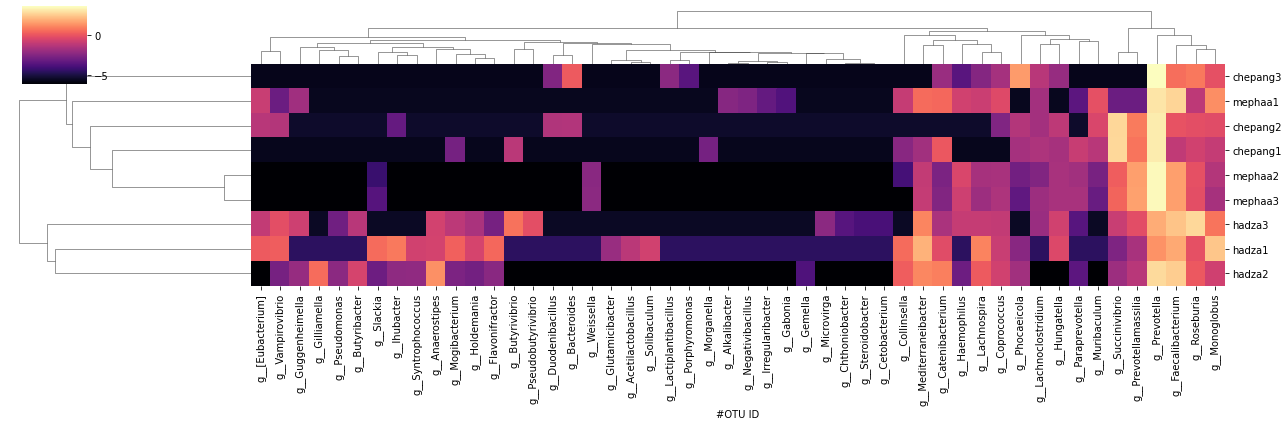

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

abundances = pd.read_table("genus.tsv", skiprows=1, index_col=0)
abundances.index = abundances.index.str.split(";").str[5]       # Use only the genus name
abundances = abundances[~abundances.index.isin(["g__", "__"])]  # remove unclassified genera
abundances = abundances.sample(50)                              # use 50 random genera

# Let's do a centered log-ratio transform: log x_i - log mean(x)
transformed = abundances.apply(
    lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5),
    axis=0)

sns.clustermap(transformed.T, cmap="magma", xticklabels=True, figsize=(18, 6))

# Exercises

Okay, that's enough time in the back seat. 

It's time to take the wheel 🚗 

Now you can dive into the data 🏊

## Exercise - Plant a Tree

One visualization that we did not spend a lot of time on was the phylogentic tree of our ASVs. Let's change that! We have seen that there are genera that appear in multiple populations in the previous step. But are the organisms in that genus actually the same?

Let's annotate the tree with our taxonomic classifications and abundances. We will use the empress plugin again but this time with the `community-plot` option. I filled in a template of the command for you. Can you figure out what has to go in the empty spaces?

**QUESTIONS:**

1) Are some of the branch lengths on the tree longer than you would expect? Do you notice anything interesting or suspicious about the taxonomic identities of these branches?

2) Can you find examples of phyla that are polyphyletic (i.e. where clusters of ASVs from the same phylum are found in different locations on the tree, showing different commmon ancestors)? What about polyphyletic taxa at lower taxonomic levels, like at the family or genus levels? Why do you think these patterns exist?

3) Use the "Shear Tree" functionality to only visualize the phylogenetic tree of the genus *Prevotella*. What do you observe? Can you figure out which of the unique V4 sequences are found only in one population? What impact might this have on studies trying to link *Prevotella* to human health?

In [19]:
# This won't run until you fill in the [EMPTY] spots with the right files ;)

!qiime empress community-plot \
    --i-tree tree/rooted_tree.qza \
    --i-feature-table dada2/table.qza \
    --m-sample-metadata-file data/metadata.tsv \
    --m-feature-metadata-file taxa.qza \
    --o-visualization community-tree-viz.qzv

Saved Visualization to: community-tree-viz.qzv


This is what the command looks like with everything filled in. This command will create the same tree as before, but you can now annotate it with a lot more information, and hovering over a node will now also show its taxonomic classification. Another thing that can be helpful is to collapse nodes on a particular taxonomic rank. For instance, you could collapse on the genus level to reduce the large number of external nodes (and the unclassified ones). 

![Example visualization](https://github.com/Gibbons-Lab/isb_course_2021/raw/main/docs/16S/assets/community_tree.png)

Let's get to the questions:

**1)** There are definitely some very long branches, what could be happening? Hovering over those very separate nodes you see that some of them have no classification, sometimes not even on the kingdom level. Interestingly, bacteria are not the only organisms that have a 16S gene. But the GreenGenes database mostly covers bacteria. The ones not classified on the kingdom level are thus likely sequences coming from 16S genes from another Domain, such as archaea. However, many of these very long branches are still classified as bacteria, and in many cases get classified as mitochondria or choloroplasts. First, of all it's really hard to distinguish mitochondria and chloroplast based on the V4 region alone. These organelles have diverged a lot from other bacteria, however they are still related to bacteria, which is somewhat consistent with [endosymbiotic theory](https://en.wikipedia.org/wiki/Symbiogenesis). Mitochondria, chloroplasts, and plastids often still contain their own genomes, seperate from their eukaryotic host cells (i.e. plants, animals, fungi, protists), and their internal 16S genes are still close enough to bacteria that the V4 primers will amplify them.

**2)** In most cases you would expect that taxonomy should match the tree that you obtain by aligning the V4 sequences. After all taxonomies like NCBI, GreenGenes, or SILVA are often built by aligning the the core proteins, full 16S gene, or other parts of the genome. These molecular taxonomies are often designed to be monophyletic. However, initial taxonomic classification of microbes in the 19th and 20th centuries was based upon phenotypic assays. And as we see in the metabolic modeling course, sometimes unrelated taxa can show similar metabolic functionality. This is why you will find, for instance, genera like `Prevotella_1`, `Prevotella_2`, and `Prevotella_3` in SILVA. The sequences from organisms classified originally as Prevotella fell into polyphyletic groups (i.e. they didn't all share the same common ancestor) and were thus split up further into monopyletic clades. When building trees from amplicon sequencing data, you will often see examples of polyphyletic taxa.  You can further explore these polyphyletic taxa by coloring nodes by their environment, and you will often see that many of those polyphyletic groups are found in distinct environments.

**3)** Shearing the tree you will that there is a Prevotella sub-tree with quite a lot of structure to it. Though, of course, no Prevotella ASVs are completely distant from each other there are some branches with quite a bit of phylogenetic distance between them, forming distinct clades. You will find both cases. Some ASVs in the Prevotella genus can be found in individuals from all 3 ethnic groups but many of them appear only in a single ethnic group and in many examples only in a single individual. So if there is already notable differences in the V4 region what does that mean for the rest of the genome? Well it *may* show quite some differences as well meaning that those clades are not the exact same organisms. So they may very well behave differently from the Prevotella strains observed in North-American and European populations, having distinct or maybe even no connection to human health in those specific ethnic groups. Thus one can not generally extrapolate microbiome-health connection from overrepresented groups to other populations and communities.1

<br><br><br>

---

# 🦠 Space for your own exploration

Feel free to use this space to run some additional analyses. If you rerun all the previous cells in the notebook (`Runtime > Run All`) you should be all set to start working on the previously generated artifacts. Remember that you can get help in the Slack channel and also in the [Qiime 2 documentation](https://docs.qiime2.org).

In [20]:
# You can add more code cells with the "+ Code" button on the top right
